In [36]:
import os
import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
KEYSPACE = "sparkassandra"
APP_NAME = KEYSPACE
CASSANDRA_IP = "192.168.5.131"

## Init PySpark

In [38]:
SUBMIT_ARGS = "--packages com.databricks:spark-csv_2.11:1.2.0,com.datastax.spark:spark-cassandra-connector_2.10:1.6.0-M1 pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [39]:
# Make sure the driver and workers all use Python2
os.environ['PYSPARK_PYTHON'] = '/opt/conda/envs/python2/bin/python'

In [40]:
#Init Spark Conf
conf = pyspark.SparkConf().setAppName(APP_NAME)
conf.set("spark.cassandra.connection.host",CASSANDRA_IP)

In [41]:
# Init Spark Context
sc = pyspark.SparkContext('local[*]', conf = conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=sparkassandra, master=local[*]) created by __init__ at <ipython-input-6-1db1d4522cfe>:2 

In [42]:
# Init Spark SQL Context
sql_ctx = SQLContext(sc)

## Load Flight Data from Cassandra (us_flights table)

In [43]:
flights_df = sql_ctx.read.format("org.apache.spark.sql.cassandra").options(table="us_flights", keyspace=KEYSPACE).load()

In [44]:
flights_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- actualelapsedtime: string (nullable = true)
 |-- airtime: string (nullable = true)
 |-- arrdelay: string (nullable = true)
 |-- arrtime: string (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- cancelled: string (nullable = true)
 |-- carrierdelay: string (nullable = true)
 |-- crsarrtime: string (nullable = true)
 |-- crsdeptime: string (nullable = true)
 |-- crselapsedtime: string (nullable = true)
 |-- dayofmonth: string (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- depdelay: string (nullable = true)
 |-- deptime: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- diverted: string (nullable = true)
 |-- flightnum: string (nullable = true)
 |-- lateaircraftdelay: string (nullable = true)
 |-- month: string (nullable = true)
 |-- nasdelay: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- securitydelay: string (nullable = true)
 |-

In [45]:
def convertColumn(df, name, newType) :
    df_1 = df.withColumnRenamed(name, "swap")
    df_1 = df_1.withColumn(name, df_1["swap"].cast(newType)).drop("swap")
    return df_1

In [46]:
flights_df = convertColumn(flights_df, "dayofweek", "int")
flights_df = convertColumn(flights_df, "arrdelay", "int")
flights_df = convertColumn(flights_df, "depdelay", "int")

In [47]:
flights_df.registerTempTable("flight")

## When is the best day of week to fly to minimise delays?

In [48]:
# SQL Request method
#sql_ctx.sql("""SELECT DayOfWeek as weekday, avg(ArrDelay) as avg_delay 
#                                FROM flight
#                                GROUP BY DayOfWeek
#                                ORDER BY avg_delay DESC""").show()

In [49]:
# DataFrame syntax
df_minimise_delays_weekday = (flights_df
                              .select('dayofweek', 'arrdelay')
                              .groupBy('dayofweek')
                              .agg(F.avg('arrdelay').alias('AVG_DELAY_ARR')))

In [50]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def convert_day_of_week(val):
    week   = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday',
              'Sunday']
    
    return week[int(val)-1]


In [51]:
# NOTE: it seems that calls to udf() must be after SparkContext() is called
udf_convert_day_of_week = udf(convert_day_of_week, StringType())

In [52]:
df_minimise_delays_weekday = df_minimise_delays_weekday.withColumn("DAY_OF_WEEK", udf_convert_day_of_week(df_minimise_delays_weekday['dayofweek']))

In [53]:
df_minimise_delays_weekday[["DAY_OF_WEEK", "AVG_DELAY_ARR"]].show()

+-----------+------------------+
|DAY_OF_WEEK|     AVG_DELAY_ARR|
+-----------+------------------+
|     Monday| 9.442378253978593|
|    Tuesday| 11.52004276658562|
|  Wednesday|11.254871344808834|
|   Thursday|  9.78082616248946|
|     Friday| 8.802137207389704|
|   Saturday|5.9339265485323205|
|     Sunday| 9.164291502105065|
+-----------+------------------+



<function matplotlib.pyplot.legend>

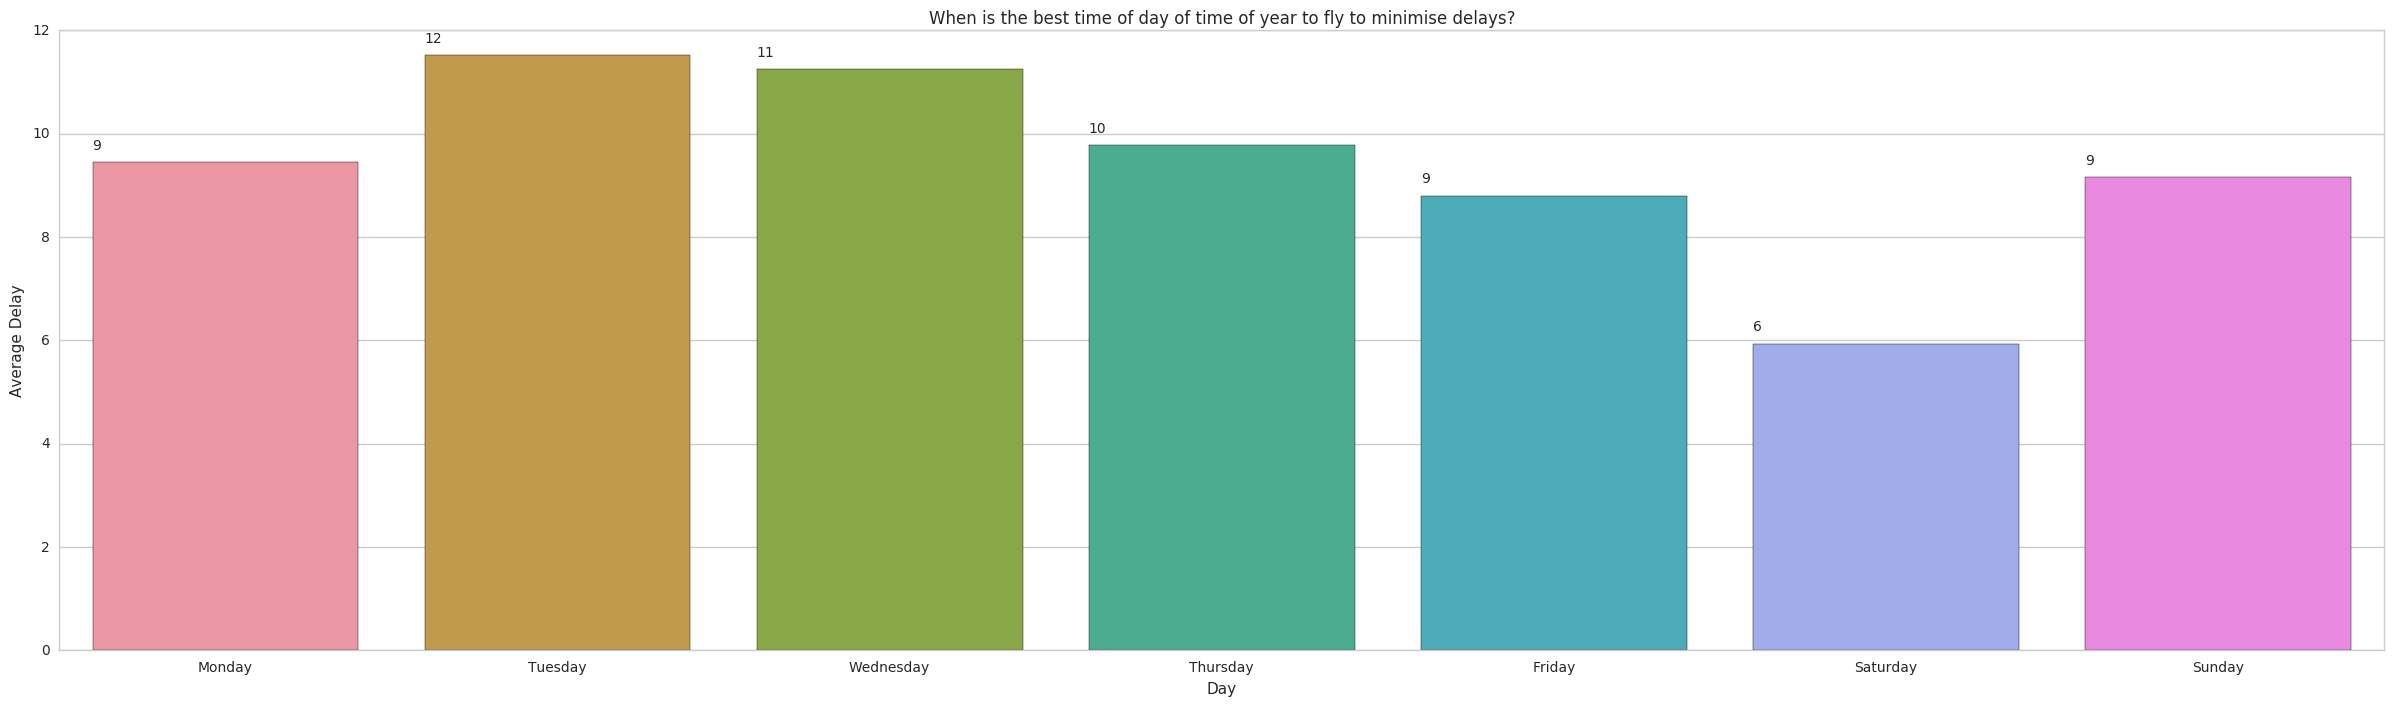

In [21]:
sns.set_style('whitegrid')
df_minimise_delays_weekday_pd = df_minimise_delays_weekday.toPandas()

plt.figure(figsize=(30,8))
ax = sns.barplot(x='DAY_OF_WEEK', y='AVG_DELAY_ARR', data=df_minimise_delays_weekday_pd)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+ 0.25, '%1.00f'%p.get_height())
plt.title('When is the best time of day of time of year to fly to minimise delays?')
plt.xlabel('Day')
plt.ylabel('Average Delay')
plt.legend

## When is the best day of week of month to fly to minimise delays?

In [26]:
df_minimise_delays_weekday_month = (flights_df
                               .select('month', 'dayofweek', 'arrdelay')
                               .groupBy('dayofweek').pivot('month').avg('arrdelay'))
# Create Column DAY_OF_WEEK : convert int => string value
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumn("DAY_OF_WEEK", udf_convert_day_of_week(df_minimise_delays_weekday.dayofweek))
# Drop DayOfWeek (int value)
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.drop("dayofweek")
# Update column name : convert int month to str month
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("1", "January")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("2", "February")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("3", "March")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("4", "April")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("5", "May")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("6", "June")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("7", "July")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("8", "August")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("9", "September")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("10", "October")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("11", "November")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("12", "December")
df_minimise_delays_weekday_month.show()

+------------------+------------------+------------------+-----------+
|           October|          November|          December|DAY_OF_WEEK|
+------------------+------------------+------------------+-----------+
| 4.893243219944484| 8.851362302640771|15.042915942559224|     Monday|
| 6.295279780295228|10.493120825849653|  16.8119710410931|    Tuesday|
|6.6576942261055025| 9.909521803244154|16.124617693701857|  Wednesday|
| 7.388888126381092| 9.391177610095383|12.580171919770773|   Thursday|
| 7.298999395238881| 6.916164770614915|12.661967447225324|     Friday|
| 3.705643211219925| 3.270535215607727|11.399349655700076|   Saturday|
|  5.44264960971379| 9.673733386555492|12.370471454742589|     Sunday|
+------------------+------------------+------------------+-----------+



In [27]:
# Convert to Pandas
pd_minimise_delays_weekday_month = df_minimise_delays_weekday_month.toPandas()

# Add Month column name to index columns
pd_minimise_delays_weekday_month.columns.names = ['Month']

# Update index values by DAY_OF_WEEK values & drop DAY_OF_WEEK columns
pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.rename(index=pd_minimise_delays_weekday_month.DAY_OF_WEEK).drop('DAY_OF_WEEK', axis=1)
pd_minimise_delays_weekday_month

Month,October,November,December
Monday,4.893243,8.851362,15.042916
Tuesday,6.295280,10.493121,16.811971
Wednesday,6.657694,9.909522,16.124618
Thursday,7.388888,9.391178,12.580172
Friday,7.298999,6.916165,12.661967
Saturday,3.705643,3.270535,11.399350
Sunday,5.442650,9.673733,12.370471


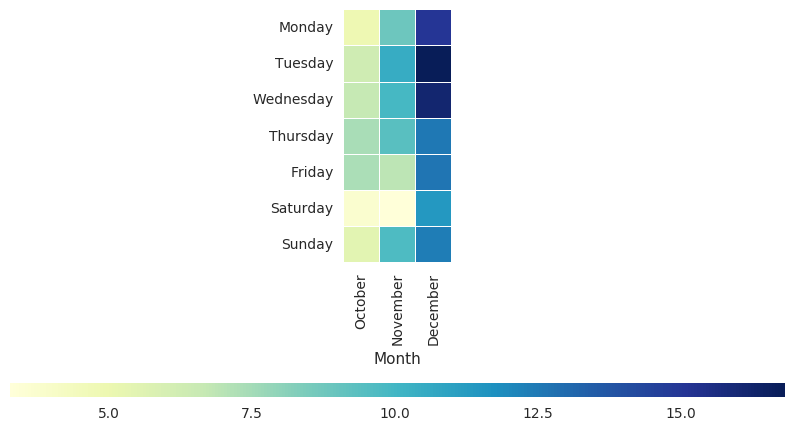

In [28]:
# Draw a heatmap 
grid_kws = {"height_ratios": (.9, .05), "hspace": 0.9}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(10, 5),gridspec_kw=grid_kws)
sns.heatmap(pd_minimise_delays_weekday_month, ax=ax, linewidths=0.01, cmap="YlGnBu", square=True, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})

## Load Airports Data

In [30]:
airports_df = sql_ctx.read.format("org.apache.spark.sql.cassandra").options(table="airports", keyspace=KEYSPACE).load()

In [31]:
airports_df.printSchema()

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- state: string (nullable = true)



## When is the best airport to fly to minimise delays?

In [32]:
df_minimise_delays_airport_dest = (flights_df
                              .select('dest', 'arrdelay')
                              .groupBy('dest')
                              .agg(F.avg('arrdelay').alias('AVG_DELAY_ARR'))
                              .sort(F.desc('AVG_DELAY_ARR')))

In [34]:
# merge with airport data

df_minimise_delays_airport_dest = (df_minimise_delays_airport_dest
                 .join(airports_df, df_minimise_delays_airport_dest.dest == airports_df.iata, 'inner'))
df_minimise_delays_airport_dest.show(4)

+----+-----------------+----+-------------------+-------------+-------+-----------+------------+-----+
|dest|    AVG_DELAY_ARR|iata|            airport|         city|country|        lat|        long|state|
+----+-----------------+----+-------------------+-------------+-------+-----------+------------+-----+
| PIH|             59.0| PIH| Pocatello Regional|    Pocatello|    USA|42.91130556|-112.5958611|   ID|
| RDD|24.15015015015015| RDD|  Redding Municipal|      Redding|    USA|40.50898361|-122.2934019|   CA|
| YKM|             23.6| YKM|Yakima Air Terminal|       Yakima|    USA|46.56816972|-120.5440594|   WA|
| ACV|22.33433734939759| ACV|             Arcata|Arcata/Eureka|    USA|40.97811528|-124.1086189|   CA|
+----+-----------------+----+-------------------+-------------+-------+-----------+------------+-----+
only showing top 4 rows



In [35]:
pd_minimise_delays_airport_dest = df_minimise_delays_airport_dest.toPandas()

In [ ]:
pd_minimise_delays_airport_dest.to_csv("pd_minimise_delays_airport_dest.csv", sep=";")